In [ ]:
!pip install torch==2.8.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 --only-binary :all:

Looking in indexes: https://download.pytorch.org/whl/cu121


In [ ]:
!pip install transformers accelerate pandas scikit-learn wandb unidecode nltk seaborn tqdm emoji --only-binary :all:

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 25.6 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('punkt')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModel, get_scheduler
import torch.nn.functional as F

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import wandb
import re
from unidecode import unidecode
from nltk.tokenize import sent_tokenize
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
class CFG:
    MODEL_NAME = 'vinai/bertweet-base'
    TOKENIZER = AutoTokenizer.from_pretrained(MODEL_NAME)

    MAX_LEN = 128
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #kept same parameters as HAN-BERT notebook
    FP16 = True
    EPOCHS = 50
    LEARNING_RATE = 3e-5
    BATCH_SIZE = 8
    ACCUMULATION_STEPS = 2
    WARMUP_RATIO = 0.06
    LABEL_SMOOTHING = 0.1

    WEIGHT_DECAY = 0.01
    SCHEDULER = "r-drop"
    DROPOUT = 0.3
    CLIP_GRAD_NORM = 1.0
    R_DROP_ALPHA = 5

    NUM_WORKERS = 0
    WANDB_PROJECT = "BERT-Emotion-Ensemble" # Updated project name
    PATIENCE = 4

In [ ]:
# Load data
train_df = pd.read_csv("emotion-labels-train.csv")
val_df = pd.read_csv("emotion-labels-val.csv")
test_df = pd.read_csv("emotion-labels-test.csv")

# Preprocessing function
def pre_process_document(text):
    text = re.sub(r'<[^>]+>', ' ', text)
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = unidecode(text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

In [ ]:
# Apply preprocessing and label encoding
train_df['text'] = train_df['text'].apply(pre_process_document)
val_df['text'] = val_df['text'].apply(pre_process_document)
test_df['text'] = test_df['text'].apply(pre_process_document)

le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['label'])
val_df['label'] = le.transform(val_df['label'])
test_df['label'] = le.transform(test_df['label'])

NUM_CLASSES = len(le.classes_)
CLASS_NAMES = le.classes_
print(f"Classes: {CLASS_NAMES}")

Classes: ['anger' 'fear' 'joy' 'sadness']


In [ ]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row.text
        label = row.label

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # Ensure token_type_ids are included
        if 'token_type_ids' not in encoding:
             encoding['token_type_ids'] = torch.zeros_like(encoding['input_ids'])


        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'token_type_ids': encoding['token_type_ids'].squeeze(), # Include token_type_ids
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets and dataloaders
train_dataset = BERTDataset(train_df, CFG.TOKENIZER, CFG.MAX_LEN)
val_dataset = BERTDataset(val_df, CFG.TOKENIZER, CFG.MAX_LEN)
test_dataset = BERTDataset(test_df, CFG.TOKENIZER, CFG.MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True, num_workers=CFG.NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)

In [ ]:
# REMOVED: WordAttention and SentenceAttention classes are no longer needed.

# REPLACED: HierarchicalAttentionNetwork is replaced with a standard BERTClassifier.
class BERTClassifier(nn.Module):
    def __init__(self, model_name, num_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        hidden_size = self.bert.config.hidden_size
        self.dropout = nn.Dropout(CFG.DROPOUT)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids=None): # Add token_type_ids
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids) # Pass token_type_ids
        # Use the pooled output which is suitable for classification
        pooled_output = bert_output.pooler_output
        dropped_output = self.dropout(pooled_output)
        logits = self.fc(dropped_output)
        return logits

In [ ]:
# --- Loss Function (Unchanged) ---
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, preds, target):
        n_classes = preds.size(-1)
        log_preds = torch.log_softmax(preds, dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(log_preds)
            true_dist.fill_(self.smoothing / (n_classes - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), 1.0 - self.smoothing)
        return torch.mean(torch.sum(-true_dist * log_preds, dim=-1))

# --- Scheduler (Unchanged) ---
def get_rdrop_scheduler(optimizer, num_warmup_steps, num_training_steps):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return (1.0 - progress) ** 0.5
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# --- KL Loss for R-Drop (Unchanged) ---
def compute_kl_loss(p, q, pad_mask=None):
    p_loss = F.kl_div(F.log_softmax(p, dim=-1), F.softmax(q, dim=-1), reduction='none')
    q_loss = F.kl_div(F.log_softmax(q, dim=-1), F.softmax(p, dim=-1), reduction='none')
    if pad_mask is not None:
        p_loss.masked_fill_(pad_mask, 0.)
        q_loss.masked_fill_(pad_mask, 0.)
    p_loss = p_loss.sum(dim=-1)
    q_loss = q_loss.sum(dim=-1)
    kl_loss = (p_loss + q_loss) / 2
    return kl_loss.mean()

# --- Training and Evaluation Functions (Unchanged) ---
def train_one_epoch(model, dataloader, optimizer, scheduler, scaler, device, criterion):
    # This function works without modification
    model.train()
    total_loss = 0
    for i, batch in enumerate(tqdm(dataloader, desc="Training")):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device) # Get token_type_ids
        labels = batch['labels'].to(device)

        with torch.cuda.amp.autocast(enabled=CFG.FP16):
            logits1 = model(input_ids, attention_mask, token_type_ids) # Pass token_type_ids
            logits2 = model(input_ids, attention_mask, token_type_ids) # Pass token_type_ids
            ce_loss = (criterion(logits1, labels) + criterion(logits2, labels)) / 2
            kl_loss = compute_kl_loss(logits1, logits2)
            loss = ce_loss + (CFG.R_DROP_ALPHA * kl_loss)
            loss = loss / CFG.ACCUMULATION_STEPS

        scaler.scale(loss).backward()
        if (i + 1) % CFG.ACCUMULATION_STEPS == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.CLIP_GRAD_NORM)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * CFG.ACCUMULATION_STEPS
    return total_loss / len(dataloader)

def evaluate(model, dataloader, device, criterion):
    # This function works without modification
    model.eval()
    all_logits, all_labels, total_loss = [], [], 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device) # Get token_type_ids
            labels = batch['labels'].to(device)

            with torch.cuda.amp.autocast(enabled=CFG.FP16):
                logits = model(input_ids, attention_mask, token_type_ids) # Pass token_type_ids
                if criterion:
                    loss = criterion(logits, labels)
                    total_loss += loss.item()
            all_logits.append(logits.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_logits = np.vstack(all_logits)
    preds_labels = np.argmax(all_logits, axis=1)
    metrics = {
        "loss": total_loss / len(dataloader) if criterion else 0,
        "accuracy": accuracy_score(all_labels, preds_labels),
        "f1": f1_score(all_labels, preds_labels, average='weighted'),
        "precision": precision_score(all_labels, preds_labels, average='weighted', zero_division=0),
        "recall": recall_score(all_labels, preds_labels, average='weighted', zero_division=0)
    }
    return metrics, np.array(all_labels), all_logits

# --- Early Stopper (Unchanged) ---
class EarlyStopper:
    def __init__(self, patience=4):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.should_stop = False

    def step(self, loss):
        if loss < self.best_loss:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True

In [ ]:
def run_training(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    model = BERTClassifier(CFG.MODEL_NAME, NUM_CLASSES).to(CFG.DEVICE)
    optimizer = AdamW(model.parameters(), lr=CFG.LEARNING_RATE, weight_decay=CFG.WEIGHT_DECAY)

    total_steps = len(train_loader) // CFG.ACCUMULATION_STEPS * CFG.EPOCHS
    num_warmup_steps = int(total_steps * CFG.WARMUP_RATIO)
    scheduler = get_rdrop_scheduler(optimizer, num_warmup_steps, total_steps)

    scaler = torch.cuda.amp.GradScaler(enabled=CFG.FP16)
    criterion = LabelSmoothingCrossEntropy(smoothing=CFG.LABEL_SMOOTHING)
    stopper = EarlyStopper(patience=CFG.PATIENCE)
    config_dict = {k: v for k, v in vars(CFG).items() if not k.startswith('__') and not callable(v)}
    run = wandb.init(project=CFG.WANDB_PROJECT, name=f"Seed_{seed}", config=config_dict, reinit=True)

    best_val_loss = float('inf')
    for epoch in range(CFG.EPOCHS):
        print(f"\n--- Seed {seed} | Epoch {epoch+1}/{CFG.EPOCHS} ---")
        train_loss = train_one_epoch(model, train_loader, optimizer, scheduler, scaler, CFG.DEVICE, criterion)
        val_metrics, _, _ = evaluate(model, val_loader, CFG.DEVICE, criterion)

        print(f"Val Loss: {val_metrics['loss']:.4f}, Val Acc: {val_metrics['accuracy']:.4f}")
        wandb.log({
            "epoch": epoch + 1, "train_loss": train_loss,
            **{f"val_{k}": v for k, v in val_metrics.items()}
        })

        if val_metrics["loss"] < best_val_loss:
            print(f"✅ Validation loss improved to {val_metrics['loss']:.4f}. Saving model.")
            best_val_loss = val_metrics["loss"]
            torch.save(model.state_dict(), f"model_seed_{seed}.pth")

        stopper.step(val_metrics["loss"])
        if stopper.should_stop:
            print("⏹ Early stopping triggered.")
            break
    run.finish()


In [ ]:
# Run training for all seeds
seeds = [101, 2468, 90210, 3141, 5555]
for s in seeds:
    run_training(s)


--- Seed 101 | Epoch 1/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 1.3334, Val Acc: 0.3977
✅ Validation loss improved to 1.3334. Saving model.

--- Seed 101 | Epoch 2/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.7110, Val Acc: 0.8473
✅ Validation loss improved to 0.7110. Saving model.

--- Seed 101 | Epoch 3/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.6821, Val Acc: 0.8559
✅ Validation loss improved to 0.6821. Saving model.

--- Seed 101 | Epoch 4/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.6552, Val Acc: 0.8790
✅ Validation loss improved to 0.6552. Saving model.

--- Seed 101 | Epoch 5/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.6693, Val Acc: 0.8732

--- Seed 101 | Epoch 6/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.7075, Val Acc: 0.8617

--- Seed 101 | Epoch 7/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.7039, Val Acc: 0.8818

--- Seed 101 | Epoch 8/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.7155, Val Acc: 0.8761
⏹ Early stopping triggered.


epoch,▁▂▃▄▅▆▇█
train_loss,█▅▃▂▂▁▁▁
val_accuracy,▁▇██████
val_f1,▁███████
val_loss,█▂▁▁▁▂▂▂
val_precision,▁▇██████
val_recall,▁▇██████
epoch,8
train_loss,0.52579
val_accuracy,0.87608
val_f1,0.87707



--- Seed 2468 | Epoch 1/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 1.3096, Val Acc: 0.4236
✅ Validation loss improved to 1.3096. Saving model.

--- Seed 2468 | Epoch 2/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.7137, Val Acc: 0.8559
✅ Validation loss improved to 0.7137. Saving model.

--- Seed 2468 | Epoch 3/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.6795, Val Acc: 0.8646
✅ Validation loss improved to 0.6795. Saving model.

--- Seed 2468 | Epoch 4/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.6624, Val Acc: 0.8934
✅ Validation loss improved to 0.6624. Saving model.

--- Seed 2468 | Epoch 5/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.6681, Val Acc: 0.8963

--- Seed 2468 | Epoch 6/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.6580, Val Acc: 0.8991
✅ Validation loss improved to 0.6580. Saving model.

--- Seed 2468 | Epoch 7/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.6824, Val Acc: 0.8876

--- Seed 2468 | Epoch 8/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.7537, Val Acc: 0.8559

--- Seed 2468 | Epoch 9/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.6820, Val Acc: 0.8905

--- Seed 2468 | Epoch 10/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.7241, Val Acc: 0.8617
⏹ Early stopping triggered.


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▇▇████▇█▇
val_f1,▁▇█████▇██
val_loss,█▂▁▁▁▁▁▂▁▂
val_precision,▁▇████████
val_recall,▁▇▇████▇█▇
epoch,10
train_loss,0.50223
val_accuracy,0.86167
val_f1,0.86185



--- Seed 90210 | Epoch 1/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 1.3326, Val Acc: 0.4121
✅ Validation loss improved to 1.3326. Saving model.

--- Seed 90210 | Epoch 2/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.7408, Val Acc: 0.8300
✅ Validation loss improved to 0.7408. Saving model.

--- Seed 90210 | Epoch 3/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.6381, Val Acc: 0.8818
✅ Validation loss improved to 0.6381. Saving model.

--- Seed 90210 | Epoch 4/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.6213, Val Acc: 0.8963
✅ Validation loss improved to 0.6213. Saving model.

--- Seed 90210 | Epoch 5/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.6574, Val Acc: 0.8876

--- Seed 90210 | Epoch 6/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.6547, Val Acc: 0.8847

--- Seed 90210 | Epoch 7/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.7192, Val Acc: 0.8703

--- Seed 90210 | Epoch 8/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.7957, Val Acc: 0.8588
⏹ Early stopping triggered.


epoch,▁▂▃▄▅▆▇█
train_loss,█▅▃▂▂▁▁▁
val_accuracy,▁▇█████▇
val_f1,▁▇██████
val_loss,█▂▁▁▁▁▂▃
val_precision,▁▇██████
val_recall,▁▇█████▇
epoch,8
train_loss,0.51393
val_accuracy,0.85879
val_f1,0.85854



--- Seed 3141 | Epoch 1/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 1.3049, Val Acc: 0.3919
✅ Validation loss improved to 1.3049. Saving model.

--- Seed 3141 | Epoch 2/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.7074, Val Acc: 0.8530
✅ Validation loss improved to 0.7074. Saving model.

--- Seed 3141 | Epoch 3/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.6527, Val Acc: 0.8963
✅ Validation loss improved to 0.6527. Saving model.

--- Seed 3141 | Epoch 4/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.6380, Val Acc: 0.9020
✅ Validation loss improved to 0.6380. Saving model.

--- Seed 3141 | Epoch 5/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.6656, Val Acc: 0.9049

--- Seed 3141 | Epoch 6/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.6689, Val Acc: 0.8991

--- Seed 3141 | Epoch 7/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.6953, Val Acc: 0.8703

--- Seed 3141 | Epoch 8/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.6784, Val Acc: 0.8934
⏹ Early stopping triggered.


epoch,▁▂▃▄▅▆▇█
train_loss,█▅▃▂▂▁▁▁
val_accuracy,▁▇██████
val_f1,▁▇██████
val_loss,█▂▁▁▁▁▂▁
val_precision,▁▇██████
val_recall,▁▇██████
epoch,8
train_loss,0.512
val_accuracy,0.89337
val_f1,0.89384



--- Seed 5555 | Epoch 1/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 1.3291, Val Acc: 0.4006
✅ Validation loss improved to 1.3291. Saving model.

--- Seed 5555 | Epoch 2/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.7197, Val Acc: 0.8530
✅ Validation loss improved to 0.7197. Saving model.

--- Seed 5555 | Epoch 3/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.6852, Val Acc: 0.8473
✅ Validation loss improved to 0.6852. Saving model.

--- Seed 5555 | Epoch 4/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.6615, Val Acc: 0.8905
✅ Validation loss improved to 0.6615. Saving model.

--- Seed 5555 | Epoch 5/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.6675, Val Acc: 0.8876

--- Seed 5555 | Epoch 6/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.6929, Val Acc: 0.8790

--- Seed 5555 | Epoch 7/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.7257, Val Acc: 0.8761

--- Seed 5555 | Epoch 8/50 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Val Loss: 0.7022, Val Acc: 0.8847
⏹ Early stopping triggered.


epoch,▁▂▃▄▅▆▇█
train_loss,█▅▃▂▂▁▁▁
val_accuracy,▁▇▇█████
val_f1,▁█▇█████
val_loss,█▂▁▁▁▁▂▁
val_precision,▁▇▇█████
val_recall,▁▇▇█████
epoch,8
train_loss,0.52274
val_accuracy,0.88473
val_f1,0.88499


In [ ]:
all_train_logits, all_val_logits, all_test_logits = [], [], []
train_labels = train_df['label'].values
val_labels = val_df['label'].values
test_labels = test_df['label'].values

In [ ]:
# --- Gather Logits from Saved Models ---
for s in seeds:
    print(f"Loading model from seed {s} and gathering logits")
    # MODIFIED: Instantiate the correct model architecture before loading weights
    model = BERTClassifier(CFG.MODEL_NAME, NUM_CLASSES).to(CFG.DEVICE)
    model.load_state_dict(torch.load(f"model_seed_{s}.pth"))
    model.eval()

    _, _, train_logits = evaluate(model, train_loader, CFG.DEVICE, criterion=None)
    _, _, val_logits = evaluate(model, val_loader, CFG.DEVICE, criterion=None)
    _, _, test_logits = evaluate(model, test_loader, CFG.DEVICE, criterion=None)

    all_train_logits.append(train_logits)
    all_val_logits.append(val_logits)
    all_test_logits.append(test_logits)

Loading model from seed 101 and gathering logits


Evaluating:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/393 [00:00<?, ?it/s]

Loading model from seed 2468 and gathering logits


Evaluating:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/393 [00:00<?, ?it/s]

Loading model from seed 90210 and gathering logits


Evaluating:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/393 [00:00<?, ?it/s]

Loading model from seed 3141 and gathering logits


Evaluating:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/393 [00:00<?, ?it/s]

Loading model from seed 5555 and gathering logits


Evaluating:   0%|          | 0/452 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/393 [00:00<?, ?it/s]

In [ ]:
# --- Ensemble by Averaging Logits ---
ensemble_train_logits = np.mean(all_train_logits, axis=0)
ensemble_val_logits = np.mean(all_val_logits, axis=0)
ensemble_test_logits = np.mean(all_test_logits, axis=0)

train_preds = np.argmax(ensemble_train_logits, axis=1)
val_preds = np.argmax(ensemble_val_logits, axis=1)
test_preds = np.argmax(ensemble_test_logits, axis=1)

In [ ]:
def calculate_metrics(labels, preds):
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='weighted'),
        "precision": precision_score(labels, preds, average='weighted', zero_division=0),
        "recall": recall_score(labels, preds, average='weighted', zero_division=0)
    }


In [ ]:
train_final_metrics = calculate_metrics(train_labels, train_preds)
val_final_metrics = calculate_metrics(val_labels, val_preds)
test_final_metrics = calculate_metrics(test_labels, test_preds)

results_df = pd.DataFrame({
    'Train': train_final_metrics,
    'Validation': val_final_metrics,
    'Test': test_final_metrics
}).T

print("\n📊 Final Ensemble Performance Metrics 📊")
print(results_df)


📊 Final Ensemble Performance Metrics 📊
            accuracy        f1  precision    recall
Train       0.266261  0.259017   0.257390  0.266261
Validation  0.904899  0.904844   0.904979  0.904899
Test        0.886378  0.886561   0.887559  0.886378


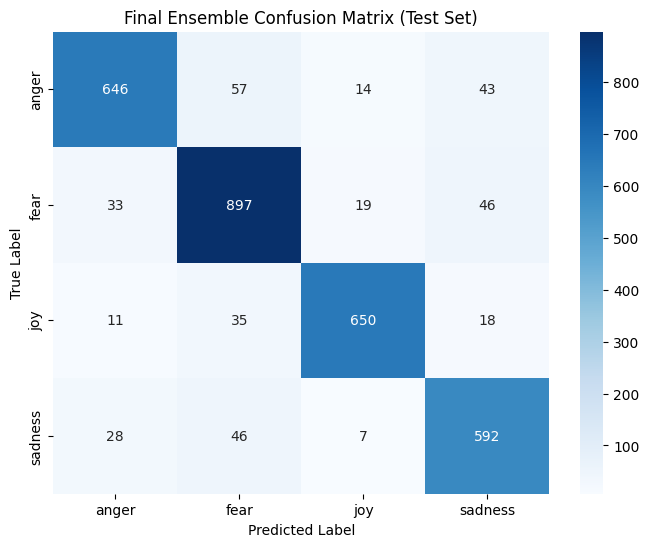

In [ ]:
def plot_cm(y_true, y_pred, title, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_cm(test_labels, test_preds, "Final Ensemble Confusion Matrix (Test Set)", CLASS_NAMES)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil


results_folder = '/content/drive/My Drive/Emotion_BERT_Ensemble_Models/'
if not os.path.exists(results_folder):
    os.makedirs(results_folder)


seeds = [101, 2468, 90210, 3141, 5555]

print("Starting to copy models to Google Drive...")

for s in seeds:
    # Path to the model saved locally in Colab
    source_path = f"model_seed_{s}.pth"

    # Destination path in your Google Drive
    destination_path = os.path.join(results_folder, f"model_seed_{s}.pth")

    if os.path.exists(source_path):
        shutil.copy(source_path, destination_path)
        print(f"Successfully copied model_seed_{s}.pth to Drive.")
    else:
        print(f"Warning: model_seed_{s}.pth not found in Colab session.")

print("\n✅ All available models have been saved to your Google Drive.")

Starting to copy models to Google Drive...
Successfully copied model_seed_101.pth to Drive.
Successfully copied model_seed_2468.pth to Drive.
Successfully copied model_seed_90210.pth to Drive.
Successfully copied model_seed_3141.pth to Drive.
Successfully copied model_seed_5555.pth to Drive.

✅ All available models have been saved to your Google Drive.
